In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
!pip install pyarrow fastparquet huggingface_hub matplotlib seaborn

  Using cached fastparquet-2024.5.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.8/683.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.0 MB/s eta 0:00:00


In [3]:
splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

/Users/calvq/miniconda3/envs/10701-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_train.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [5]:
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [6]:
df_combined.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [15]:
df = df_train.loc[:1000]
df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])


In [43]:
normalized_tfidf = normalize(tfidf_matrix)


# PCA -> KMeans

In [44]:
pca = PCA(2)
df_pca = pca.fit_transform(normalized_tfidf.toarray())

In [54]:
n_clusters = 7  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=43, n_init=10)
cluster_labels = kmeans.fit_predict(df_pca)

In [55]:
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels


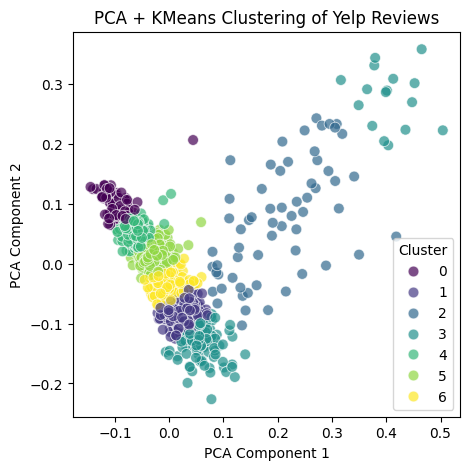

In [56]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60, alpha=0.7)
plt.title('PCA + KMeans Clustering of Yelp Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## Classifying CLusters

In [57]:
df['Cluster'] = cluster_labels

<ipython-input-57-169e9b02fc4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = cluster_labels


In [61]:
for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num}:")
    cluster_reviews = df[df['Cluster'] == cluster_num]['text']

    # Print a few sample reviews (e.g., 5) from this cluster
    for i, review in enumerate(cluster_reviews.head(2)):
        print(f"Review {i+1}: {review}\n")


Cluster 0:
Review 1: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.

Review 2: Dr. Eric Goldberg is a fantastic doctor who has correctly diagnosed every issue that my wife and I have had. Unlike many of my past doctors, Dr. Goldberg is very accessible and we have been able to schedule appointments with him and his staff very quickly. We are happy to have him in the neighborhood and look forward to b

# KMeans -> PCA

In [38]:
n_clusters = 10  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=43, n_init=10)
cluster_labels = kmeans.fit_predict(normalized_tfidf)

In [39]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(normalized_tfidf.toarray())

In [40]:
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

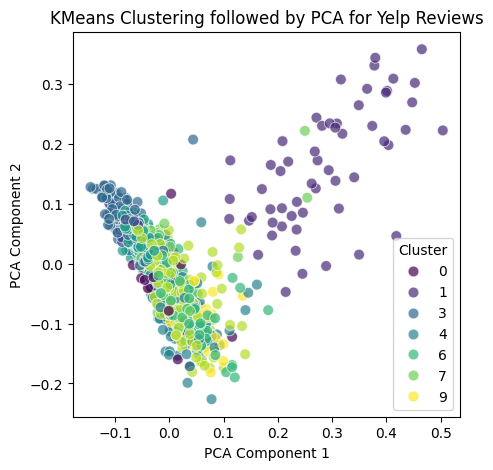

In [41]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60, alpha=0.7)
plt.title('KMeans Clustering followed by PCA for Yelp Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()